In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

# 1. 장치 설정 함수
def get_device() -> torch.device:
    """
    사용 가능한 장치를 확인 및 설정
    (GPU가 사용 가능하면 GPU를, 그렇지 않으면 CPU를 반환)
    
    Returns:
        torch.device: 사용 가능한 장치
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'사용 장치: {device}')
    return device

In [7]:
# 2. 데이터 로드 및 전처리 함수
def load_data(batch_size_train: int = 64, 
              batch_size_val: int = 100,
              batch_size_test: int = 100, 
              num_workers: int = 2,
              validation_split: float = 0.1) -> tuple:
    """
    CIFAR-10 데이터셋을 로드하고 전처리
    
    Args:
    batch_size_train (int, optional): 학습 데이터 배치 크기. Defaults to 64.
    batch_size_val (int, optional): 검증 데이터 배치 크기. Defaults to 100.
    batch_size_test (int, optional): 테스트 데이터 배치 크기. Defaults to 100.
    num_workers (int, optional): 데이터 로드 시 사용할 워커 수. Defaults to 2.
    validation_split (float, optional): 검증 데이터 비율. Defaults to 0.1.
    
    Returns:
        tuple: (trainloader, valloader, testloader, classes)
    """
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # 데이터 증강: 수평 뒤집기
        transforms.RandomCrop(32, padding=4),  # 데이터 증강: 랜덤 크롭
        transforms.ToTensor(),  # 텐서로 변환
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),  # 정규화 (평균)
                             std=(0.2023, 0.1994, 0.2010))  # 정규화 (표준편차)
    ])
    
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465),
                             std=(0.2023, 0.1994, 0.2010))
    ])

    # 전체 훈련 데이터셋 로드
    full_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                 download=True, transform=transform_train)
    
    # 훈련 데이터와 검증 데이터로 분할
    train_indices, val_indices = train_test_split(
        list(range(len(full_trainset))), # full_trainset에 대한 전체 인덱스 리스트 생성
        test_size=validation_split, # 전체 훈련셋의 10% 비율로 검증 데이터셋을 분리
        random_state=42, # 데이터 분할 시 랜덤성을 막기 위해 42라는 임의의 숫자를 지정
        stratify=full_trainset.targets # 층화 추출(stratified sampling)을 수행
    )

    # Subset을 사용하여 훈련 세트와 검증 세트 생성
    train_subset = Subset(full_trainset, train_indices)
    val_subset = Subset(full_trainset, val_indices)

    # DataLoader 생성 ---
    trainloader = DataLoader(train_subset, batch_size=batch_size_train,
                             shuffle=True, num_workers=num_workers)
    valloader = DataLoader(val_subset, batch_size=batch_size_val,
                           shuffle=False, num_workers=num_workers)

    # 테스트 데이터셋
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    # DataLoader 생성 ---
    testloader = DataLoader(testset, batch_size=batch_size_test, 
                            shuffle=False, num_workers=num_workers)
    
    # 클래스 이름 정의
    classes = ['airplane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    return trainloader, valloader, testloader, classes




# 3. 데이터 시각화 함수
def visualize_data(trainloader: DataLoader, classes: list):
    """
    학습 데이터셋의 일부 샘플을 시각화
    
    Args:
        trainloader (DataLoader): 학습 데이터 로더
        classes (list): 클래스 이름 리스트
    """
    def imshow(img):
        img = img * torch.tensor([0.2023, 0.1994, 0.2010]).view(3,1,1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)  # 정규화 해제
        npimg = img.numpy() # matplotlib 사용을 위해 tensor를 numpy 배열로 변환 
        plt.imshow(np.transpose(npimg, (1, 2, 0))) # C,H,W -> H,W,C
        plt.show() # imshow로 렌더링한 이미지를 화면에 출력
    
    # 데이터 샘플 확인
    dataiter = iter(trainloader)
    images, labels = next(dataiter) 

    imshow(torchvision.utils.make_grid(images[:16]))
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(16))) 


In [8]:

# 4. Residual Block 정의
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        """
        Residual Block을 정의
    
        Args:
            in_channels (int): 입력 채널 수
            out_channels (int): 출력 채널 수
            stride (int, optional): stride 값. Defaults to 1.
            downsample (nn.Module, optional): 다운샘플링을 위한 모듈. Defaults to None.
        """
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample # 입력을 출력과 차원 맞추기 위해 필요한 다운샘플링 모듈
    
    def forward(self, x):
        identity = x
        
        # 첫 번째 블록 ---
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        # --- --- --- --- 
        
        # 두 번째 블록 ---
        out = self.conv2(out)
        out = self.bn2(out)
        # --- --- --- --- 
        
        # x(입력)과 out(출력)의 차원을 맞추기 위해 x의 차원을 조정
        if self.downsample is not None:
            identity = self.downsample(x)
        
        # identity (원본 입력)
        # Residual Connection:
        # 입력 더하기: identity (원본 입력)를 out (Convolutional Block의 출력)과 합
        # ReLU 활성화: 최종 출력에 ReLU 활성화 함수 적용
        out += identity # 스킵 커넥션: 입력(identity)을 출력에 더함
        out = self.relu(out)  # Residual Block의 최종 출력
        
        return out

# 4. CNN 모델 정의 함수 (Residual Network 적용)
def define_model() -> nn.Module:
    """
    Residual Network을 정의
    
    Returns:
        nn.Module: 정의된 ResNet 모델
    """
    class ResNet(nn.Module):
        def __init__(self, block, layers, num_classes=10):
            super(ResNet, self).__init__()
            self.in_channels = 32 # Block의 입력 채널 수 
            self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 3채널 -> 32채널
            self.bn1 = nn.BatchNorm2d(32)
            self.relu = nn.ReLU(inplace=True)
            
            # self.layer1: 첫 번째 Residual Layer. --------
            # 블록 클래스: block (ResidualBlock)
            # 출력 채널 수: 32
            # 블록 수: layers[0] (여기서는 2)
            # 스트라이드: 기본값 1 (공간적 크기 변경 없음) --------
            # self.layer2: 두 번째 Residual Layer. --------
            # 블록 클래스: block (ResidualBlock)
            # 출력 채널 수: 64
            # 블록 수: layers[1] (여기서는 2)
            # 스트라이드: 2 (공간적 크기를 절반으로 줄임) --------
            self.layer1 = self._make_layer(block, 32, layers[0])
            self.layer2 = self._make_layer(block, 64, layers[1], stride=2)
            self.layer3 = self._make_layer(block, 128, layers[2], stride=2)
            # 여기서 stride=2를 사용하여 공간적 크기를 절반으로 줄임
            
            # 평균 풀링 및 FCL
            self.avg_pool = nn.AdaptiveAvgPool2d((1, 1)) # 모든 공간적 위치의 평균을 계산하여 고정된 크기의 출력(1x1)으로 축소
            self.fc = nn.Linear(128, num_classes) # 64차원 특징 벡터를 10차원 클래스 점수로 변환하여 최종 분류 결과를 출력
        
        # Residual Blocks을 여러 개 쌓아 하나의 Residual Layer를 생성
        def _make_layer(self, block, out_channels, blocks, stride=1):
            """
            Residual Layer를 생성
            
            Args:
                block (nn.Module): Residual Block 클래스
                out_channels (int): 출력 채널 수
                blocks (int): 블록의 개수
                stride (int, optional): stride 값. Defaults to 1.
            
            Returns:
                nn.Sequential: Residual Layer
            """
            # 다운샘플링 설정 : 
            downsample = None
            if stride != 1 or self.in_channels != out_channels:
                downsample = nn.Sequential(
                    nn.Conv2d(self.in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                    nn.BatchNorm2d(out_channels)
                )
            
            # Residual Blocks 쌓기
            layers = [] # 블록을 담기 위한 layers 빈 리스트 생성
            layers.append(block(self.in_channels, out_channels, stride, downsample)) # Residual Block을 생성할 때 첫 번째 블록은 입력과 출력의 차원을 맞추기 위해 stride와 downsample이 설정되어야함
            self.in_channels = out_channels # 다음 불록의 입력 채널을 현재 블록의 출력 채널로 업데이트
            for _ in range(1, blocks): # 두번째 블록부터는 반복문에 의하여 리스트에 쌓임
                layers.append(block(out_channels, out_channels))
            
            return nn.Sequential(*layers) # * : 언팩(Unpack) 연산자 - 언팩 연산자는 시퀀스(예: 리스트, 튜플)를 개별적인 요소로 분리하여 함수의 인자로 전달할 때 사용
        
        def forward(self, x):
            out = self.conv1(x)
            out = self.bn1(out)
            out = self.relu(out)
            
            out = self.layer1(out)
            out = self.layer2(out)
            out = self.layer3(out)
            
            out = self.avg_pool(out)
            out = torch.flatten(out, 1)
            out = self.fc(out)
            
            return out
    
    # ResNet-18과 유사한 구성 (여기서는 간단히 각 레이어에 2개의 블록을 사용)
    model = ResNet(ResidualBlock, [5, 5, 5], num_classes=10) # 모델 인스턴스화
    # print(model)
    return model

# 5. 손실 함수 및 옵티마이저 정의 함수
def get_criterion_optimizer(model: nn.Module, learning_rate: float = 0.001) -> tuple:
    """
    손실 함수와 옵티마이저를 정의
    
    Args:
        model (nn.Module): 학습할 모델
        learning_rate (float, optional): 학습률. Defaults to 0.001.
    
    Returns:
        tuple: (손실 함수, 옵티마이저)
    """
    criterion = nn.CrossEntropyLoss() # 손실 함수 객체 생성
    optimizer = optim.Adam(params=model.parameters(), lr=learning_rate) # 옵티마이저 객체 생성
    return criterion, optimizer

In [9]:
# 6. 모델 학습 함수
def train_model(model: nn.Module, 
                trainloader: DataLoader, 
                valloader: DataLoader, 
                criterion: nn.Module, 
                optimizer: optim.Optimizer, 
                device: torch.device, 
                num_epochs: int = 2) -> dict:
    """
    모델을 학습시킵니다.
    
    Args:
        model (nn.Module): 학습할 모델
        trainloader (DataLoader): 학습 데이터 로더
        valloader (DataLoader): 검증 데이터 로더
        criterion (nn.Module): 손실 함수
        optimizer (optim.Optimizer): 옵티마이저
        device (torch.device): 사용 장치
        num_epochs (int, optional): 학습할 에포크 수. Defaults to 50.
    
    Returns:
        dict: 학습 및 검증 손실과 정확도 기록
    """
    history = {
        'train_losses': [],
        'train_accuracies': [],
        'val_losses': [],
        'val_accuracies': []
    }
    
    for epoch in range(num_epochs):  # 에포크 수
        # 학습 단계
        model.train() # 훈련 모드 
        # --- 평가 지표 ---
        running_loss = 0.0
        correct = 0
        total = 0
        # ---
        
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # 기울기 초기화
            
            outputs = model(inputs)  # 순전파
            loss = criterion(outputs, labels)  # 손실 계산
            loss.backward()  # 역전파
            optimizer.step()  # 가중치 업데이트
            
            running_loss += loss.item() * inputs.size(0) # loss 
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = correct / total
        history['train_losses'].append(epoch_loss)
        history['train_accuracies'].append(epoch_acc)
        
        # 검증 단계
        model.eval()
        val_loss = 0.0
        correct_test = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(valloader.dataset)
        epoch_val_acc = correct_test / total_val
        history['val_losses'].append(epoch_val_loss)
        history['val_accuracies'].append(epoch_val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] '
              f'Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} '
              f'| Val Loss: {epoch_val_loss:.4f} | Val Acc: {epoch_val_acc:.4f}')
    
    print('Train complete')
    return history

# 7. 모델 평가 함수
def evaluate_model(model: nn.Module, 
                   testloader: DataLoader, 
                   device: torch.device) -> float:
    """
    테스트 데이터셋을 사용하여 모델을 평가
    
    Args:
        model (nn.Module): 평가할 모델
        testloader (DataLoader): 테스트 데이터 로더
        device (torch.device): 사용 장치
    
    Returns:
        float: 테스트 정확도
    """
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_accuracy = correct / total
    print(f'\nFinal Test Accuracy: {test_accuracy:.4f}')
    return test_accuracy

# 8. 학습 과정 시각화 함수
def plot_history(history: dict, num_epochs: int):
    """
    학습 과정에서의 손실과 정확도를 시각화
    
    Args:
        history (dict): 학습 및 검증 손실과 정확도 기록
        num_epochs (int): 에포크 수
    """
    epochs = range(1, num_epochs + 1)
    
    plt.figure(figsize=(12,5))
    
    # 정확도 변화
    plt.subplot(1,2,1) # (행 수, 열 수, 서브플롯 위치)
    plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracies'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Change')
    plt.legend()
    
    # 손실 변화
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_losses'], label='Train Loss')
    plt.plot(epochs, history['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Change')
    plt.legend()
    
    plt.show()

사용 장치: cpu
Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


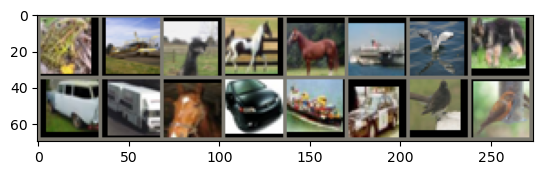

frog  airplane bird  horse horse ship  bird  dog   car   truck horse car   ship  car   bird  bird 


In [ ]:
# 9. 메인 함수
def main():
    # 장치 설정
    device = get_device()
    
    # 데이터 로드
    trainloader, valloader, testloader, classes = load_data()
    
    # 데이터 시각화
    visualize_data(trainloader, classes)
    
    # 모델 정의
    model = define_model().to(device)
    
    # 손실 함수와 옵티마이저 정의
    criterion, optimizer = get_criterion_optimizer(model)
    
    # 모델 학습
    num_epochs = 20
    history = train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs)
    
    # 모델 평가
    evaluate_model(model, testloader, device)
    
    # 학습 과정 시각화
    plot_history(history, num_epochs)

if __name__ == '__main__':
    main()
